In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
# Read the saved BGG database
game_df = pd.read_json('bgg_database.json')

In [3]:
game_df.index.name = 'gameid'
game_df = game_df.reset_index()
game_df.head()

,gameid,attributes,average_rating,description,last_updated,name,num_voters,play_time,player_count,rank,ratings,weight,weighted_rating,year
0,1,"{u'boardgamedesigner': u'Karl-Heinz Schmiel', ...",7.64052,Die Macher is a game about seven sequential po...,Tue Jan 29 22:56:21 2019,Die Macher,4752,240,"{u'1': {u'Recommended': u'1', u'Not Recommende...",208,"{u'aSoso': u'10', u'Annagul': u'7', u'the_ka':...",4.3434,7.20468,1986
1,10,"{u'boardgamedesigner': u'Alan R. Moon', u'boar...",6.73401,Elfenland is a redesign of the original White ...,Tue Jan 29 22:25:44 2019,Elfenland,7302,60,"{u'6+': {u'Recommended': u'1', u'Not Recommend...",850,"{u'Igorken': u'6', u'druvey': u'4', u'Joverowa...",2.1620,6.54036,1998
2,100169,"{u'boardgamedesigner': u'Robert Leonhard', u'b...",7.57304,Historic Gaming #7&#10;&#10;Hero of Weehawken ...,Wed Jan 30 00:49:00 2019,Hero of Weehawken,146,45,"{u'1': {u'Recommended': u'1', u'Not Recommende...",3965,"{u'userid122002': u'7', u'dougadamsau': u'8', ...",2.1579,5.72521,2011
3,100172,"{u'boardgamedesigner': u'Brad Champeny', u'boa...",6.81274,The King's birthday has arrived! Wealthy arist...,Wed Jan 30 00:49:06 2019,Seven Sisters,144,60,"{u'6+': {u'Recommended': u'0', u'Not Recommend...",5653,"{u'skelebone': u'8', u'infinity13': u'7.5', u'...",2.4118,5.62356,2012
4,1002,"{u'boardgamedesigner': u'Urs Hostettler', u'bo...",6.90081,Cosmic Eidex is an intriguing little trick-tak...,Wed Jan 30 00:33:14 2019,Cosmic Eidex,442,60,"{u'1': {u'Recommended': u'0', u'Not Recommende...",2783,"{u'dakarp': u'8', u'hurrlipurr': u'7', u'sanny...",2.6909,5.87718,1998


In [9]:
game_df = game_df[game_df['rank'] <= 3000]
game_df.to_json('bgg_database_3k.json')

In [14]:
# Create a dataframe of only the user, game ID, and score for each game
ratings = []
for i, row in game_df.iterrows():
    for user, score in row.ratings.iteritems():
        rating = (row['gameid'], user, float(score))
        ratings.append(rating)
ratings = pd.DataFrame(ratings, columns = ['gameid', 'user', 'score'])

In [15]:
ratings.head()

,gameid,user,score
0,1,aSoso,10
1,1,Annagul,7
2,1,the_ka,9
3,1,treece keenes,1
4,1,dakarp,7


In [16]:
ratings.shape

(10208493, 3)

In [17]:
# Find the distribution of number of ratings each user has given

rating_counts = ratings.groupby('user').size().reset_index()
rating_counts.columns = ['user', 'num_ratings']
rating_counts = rating_counts.sort_values('num_ratings', ascending=False)
print str(len(rating_counts)) + ' users have rated at least 1 game.'
rating_counts.head()

261259 users have rated at least 1 game.


,user,num_ratings
196282,leffe dubbel,2687
254852,we3die,2301
29777,Doel,1928
115181,Tolkana,1834
53641,JasonSaastad,1831


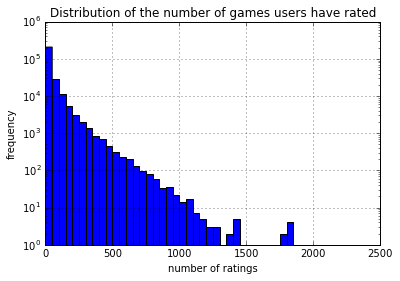

In [18]:
# Visualize above distribution

rating_counts.hist(column = 'num_ratings', bins = range(0,2550,50))
plt.title('Distribution of the number of games users have rated')
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('number of ratings')
plt.xlim(0, 2500)
plt.show()

In [19]:
# Remove users who have not rated many games

high_n_users = rating_counts[rating_counts.num_ratings >=50]
print str(len(high_n_users)) + ' users have rated at least 50 games.'
high_n_users.tail()

54502 users have rated at least 50 games.


,user,num_ratings
209993,mrdaxxos,50
116945,Tubby,50
161709,eishund,50
23437,Crz82,50
94773,RitterFips,50


In [20]:
ratings_red = ratings[ratings['user'].isin(high_n_users['user'])]
n_users = len(ratings_red.user.unique())
n_games = len(ratings_red.gameid.unique())
print str(n_users) + ' users'
print str(n_games) + ' games'

54502 users
3000 games


In [21]:
# Save matrix with only frequest raters

ratings_red.to_json('ratings_reduced.json')

In [25]:
vhigh_n_users = rating_counts[rating_counts.num_ratings >= 300]
print str(len(vhigh_n_users)) + ' users have rated at least 300 games.'

4624 users have rated at least 300 games.


In [26]:
ratings_vred = ratings[ratings['user'].isin(vhigh_n_users['user'])]
n_users = ratings_vred.user.unique().shape[0]
n_games = ratings_vred.gameid.unique().shape[0]
print str(n_users) + ' users'
print str(n_games) + ' games'

4624 users
3000 games


In [27]:
# Save matrix with only the most frequest raters

ratings_vred.to_json('ratings_vreduced.json')